In [1]:
import string
import random
from random import randint
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
from PIL import Image, ImageFont, ImageDraw
from scipy import ndimage 
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers

2023-04-09 20:40:42.450803: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/fizzer/.local/lib/python3.8/site-packages/cv2/../../lib64:/opt/ros/noetic/lib
2023-04-09 20:40:42.450822: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Setup: set file paths

In [2]:
# MODEL_SAVE_PATH = '/home/fizzer/ros_ws/src/controller_pkg/assets/models/char_recog_resize'
MODEL_SAVE_PATH = '/home/fizzer/Insync/kmackenziesecondary@gmail.com/Google Drive - Shared with me/enph353_competition/assets/models/char_recog_resize_2'
MODEL_LOAD_PATH = '/home/fizzer/ros_ws/src/controller_pkg/assets/models/character_recognition'
MODEL_INPUT_SIZE = (20, 20)
LOAD_MODEL = False

# Part 1: Test generating single letter

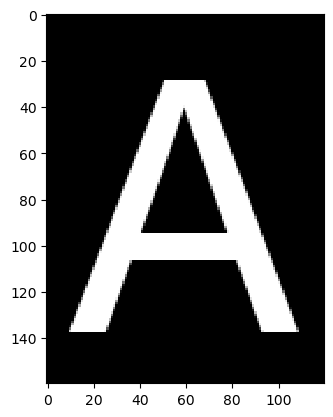

In [42]:
zeros = np.zeros(shape=(160,120), dtype=np.uint8)
# plt.imshow(zeros)
image = Image.fromarray(zeros)
draw = ImageDraw.Draw(image)
font = ImageFont.truetype(r"/usr/share/fonts/truetype/liberation/LiberationMono-Regular.ttf", 165)
text = "A"
draw.text(xy=(10,0), text=text, font=font, fill=255)

letter_image = np.array(image)
plt.imshow(letter_image, cmap='gray')

### Detect contours

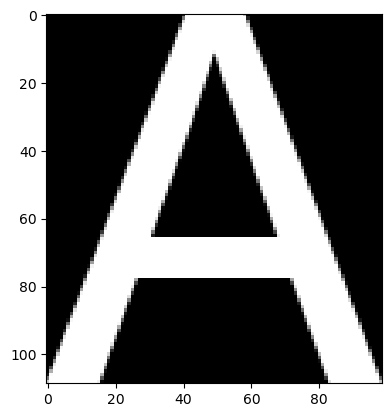

In [43]:
contours, hierarchy = cv2.findContours(letter_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
maxContour = max(contours, key=cv2.contourArea)
x,y,w,h = cv2.boundingRect(maxContour)
letter_image = letter_image[y:y+h, x:x+w]
# cv2.rectangle(letter_image,(x,y),(x+w,y+h),(255),1)
plt.imshow(letter_image, cmap='gray')

## 1.2 Dict from Character -> Index

In [4]:
chars = list(string.ascii_uppercase + string.digits)
ctoi = {c:i for i,c in enumerate(chars)}
itoc = {i:c for i,c in enumerate(chars)}
print(ctoi)

{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25, '0': 26, '1': 27, '2': 28, '3': 29, '4': 30, '5': 31, '6': 32, '7': 33, '8': 34, '9': 35}


# Part 2: Generate list of image of each character

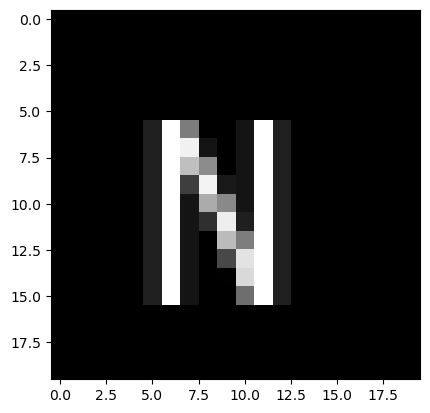

In [5]:
letter_images = []

FONT_HEIGHT = 15


for i in range(36):
    # zeros = np.zeros(shape=(int(FONT_HEIGHT * 2), int(FONT_HEIGHT * 1.5)), dtype=np.uint8)
    zeros = np.zeros(shape=MODEL_INPUT_SIZE, dtype=np.uint8)
    # plt.imshow(zeros)
    image = Image.fromarray(zeros)
    draw = ImageDraw.Draw(image)
    font = ImageFont.truetype(r"/usr/share/fonts/truetype/ubuntu/UbuntuMono-R.ttf", int(MODEL_INPUT_SIZE[0]*0.8))
    text = itoc[i]
    # print(font.getsize(text))
    draw.text(xy=(int(MODEL_INPUT_SIZE[1]*0.25), int(MODEL_INPUT_SIZE[0]*0.1)), text=text, font=font, fill=255)
    letter_image = np.array(image)
    letter_images.append(letter_image)

letter_images = np.stack([ im for im in letter_images], axis=0)
letter_images.shape

# show random one
plt.imshow(letter_images[np.random.randint(36)], cmap='gray')

## 2.2: Rotate images

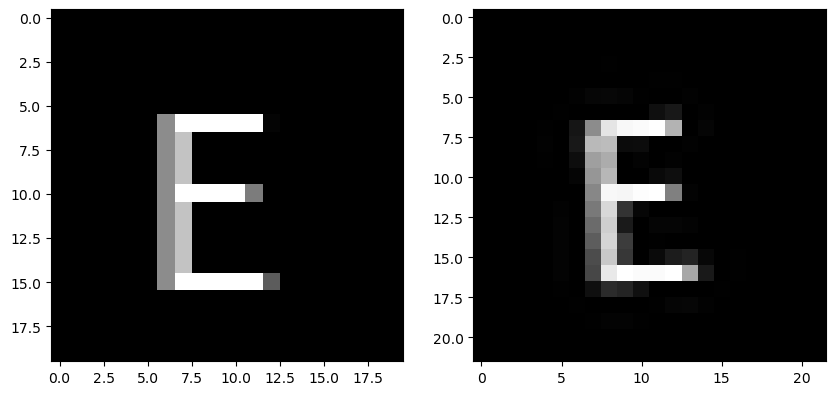

In [6]:
image = letter_images[np.random.randint(0,36)]
rotated = ndimage.interpolation.rotate(image, np.random.randint(-20,20), axes=(0,1), reshape=True)
# show random one 
fig, axs = plt.subplots(1, 2, figsize=(10, 10))
axs[0].imshow(image, cmap='gray')
axs[1].imshow(rotated, cmap='gray')

## 2.4 Perspective Transform

In [7]:
def unit_rand():
    return np.random.rand() * 2 - 1

[[ 0.9507824  -0.0460497   0.03952683]
 [ 0.02797315  0.87077492  0.27613467]
 [-0.00239605 -0.00805308  1.        ]]


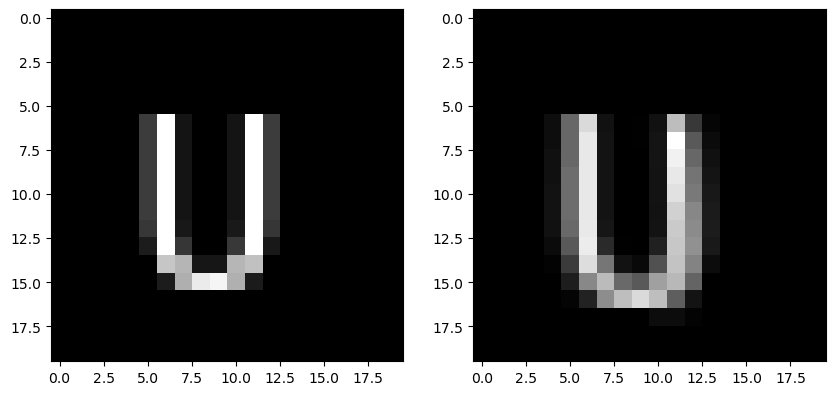

In [8]:
# Locate points of the documents
    # or object which you want to transform
image = letter_images[np.random.randint(0,36)]

RAND_RANGE = 0.8

pts1 = np.float32([[0, 0], [10, 0], [0, 10], [10, 10]])
pts2 = np.float32([[x + RAND_RANGE*unit_rand(), y + RAND_RANGE*unit_rand()] for x, y in pts1])
# Apply Perspective Transform Algorithm
matrix = cv2.getPerspectiveTransform(pts1, pts2)
print(matrix)
result = cv2.warpPerspective(image, matrix, image.T.shape, flags=cv2.INTER_LINEAR)

fig, axs = plt.subplots(1, 2, figsize=(10, 10))
axs[0].imshow(image, cmap='gray')
axs[1].imshow(result, cmap='gray')

## 2.5 Random compression and extrapolation

#### Shrink down the size of the image to something like 10x8 pixels, then resize to original, creating random data losses

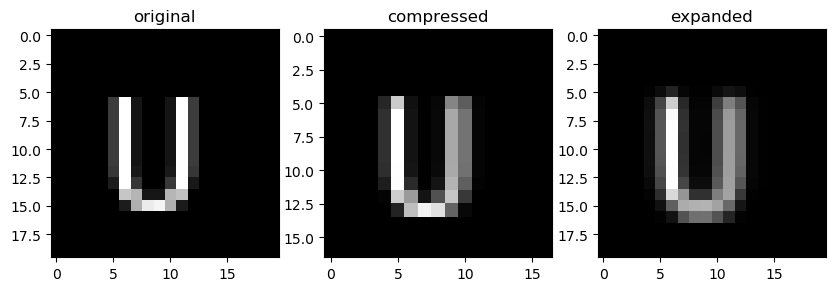

In [9]:
image = letter_images[np.random.randint(0,36)]
x_ratio = np.random.rand() * 0.3 + 0.7 # 0.3 ~ 1
y_ratio = np.random.rand() * 0.3 + 0.7 # 0.3 ~ 1
compressed = cv2.resize(image, (0,0), fx=x_ratio, fy=y_ratio)
expanded = cv2.resize(compressed, (image.shape[1], image.shape[0]))
fig, axs = plt.subplots(1, 3, figsize=(10, 10))
titles = ['original', 'compressed', 'expanded']
for i, ax in enumerate(axs):
    ax.imshow([image, compressed, expanded][i], cmap='gray')
    ax.set_title(titles[i])

## 2.5: All together

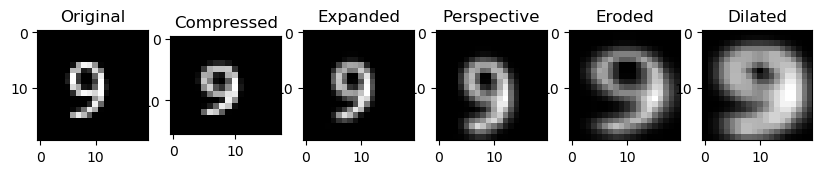

In [10]:

image = letter_images[np.random.randint(0,36)]
x_ratio = np.random.rand() * 0.4 + 0.6 # 0.6 ~ 1
y_ratio = np.random.rand() * 0.4 + 0.6 # 0.6 ~ 1
compressed = cv2.resize(image, (int(image.shape[1]*x_ratio), int(image.shape[0]*y_ratio)))
expanded = cv2.resize(compressed, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_CUBIC)
pts1 = np.float32([[0, 0], [10, 0], [0, 10], [10, 10]])
pts2 = np.float32([[x + RAND_RANGE*unit_rand(), y + RAND_RANGE*unit_rand()] for x, y in pts1])
# Apply Perspective Transform Algorithm
matrix = cv2.getPerspectiveTransform(pts1, pts2)
warped = cv2.warpPerspective(expanded, matrix, image.T.shape, flags=cv2.INTER_LINEAR)
contours, hierarchy = cv2.findContours(warped, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
x,y,w,h = cv2.boundingRect(max(contours, key = cv2.contourArea))
cropped = cv2.resize(warped[y:y+h, x:x+w], warped.T.shape)
eroded = cv2.erode(cropped, np.ones((2,2), np.uint8), iterations=1)
dilated = cv2.dilate(cropped, np.ones((2,2), np.uint8), iterations=1)


fig, axs = plt.subplots(1, 6, figsize=(10, 10))
titles = ['Original', 'Compressed', 'Expanded', 'Perspective', 'Eroded', 'Dilated']
for i, ax in enumerate(axs):
    ax.set_title(titles[i])
axs[0].imshow(image, cmap='gray')
axs[1].imshow(compressed, cmap='gray')
axs[2].imshow(expanded, cmap='gray')
axs[3].imshow(warped, cmap='gray')
axs[4].imshow(eroded, cmap='gray')
axs[5].imshow(dilated, cmap='gray')


## 2.3: Test separating two attached letters

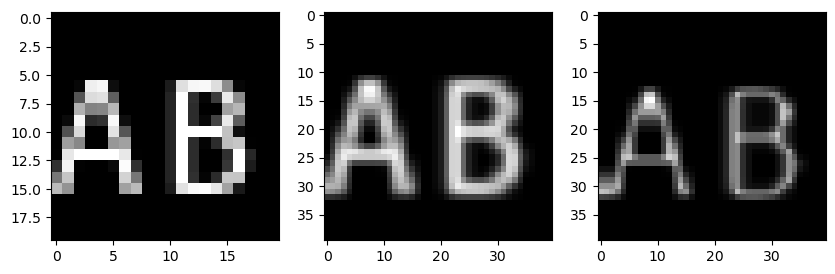

In [27]:
image = Image.fromarray(zeros)
draw = ImageDraw.Draw(image)
font = ImageFont.truetype(r"/usr/share/fonts/truetype/ubuntu/UbuntuMono-R.ttf", int(MODEL_INPUT_SIZE[0]*0.8))
text1 = 'A'
text2 = 'B'
draw.text(xy=(0, int(MODEL_INPUT_SIZE[0]*0.1)), text=text1, font=font, fill=255)
draw.text(xy=(MODEL_INPUT_SIZE[1]//2, int(MODEL_INPUT_SIZE[0]*0.1)), text=text2, font=font, fill=255)
letter_image = np.array(image)

fig, axs = plt.subplots(1, 3, figsize=(10, 10))
axs[0].imshow(letter_image, cmap='gray')
# expand image 
expanded = cv2.resize(letter_image, (0,0), fx=2, fy=2)
axs[1].imshow(expanded, cmap='gray')
# erode 
eroded = cv2.erode(expanded, np.ones((2,2), np.uint8), iterations=2)
axs[2].imshow(eroded, cmap='gray')

# Part 3: Batch-ify it

In [84]:
RAND_RANGE = 0.6

X = letter_images.copy()
Y = tf.one_hot(np.arange(36), depth=36)

# for i in range(2000):
for i in range(2000):
    # shifted = shift_image_batch(letter_images, SHIFT_RANGE, SHIFT_RANGE)
    rotated = ndimage.interpolation.rotate(letter_images, np.random.randint(-45,45), axes=(1,2), reshape=False)
    results = []
    for j in range(36):
        # x_ratio = np.random.rand() * 0.4 + 0.6 # 0.6 ~ 1
        # y_ratio = np.random.rand() * 0.4 + 0.6 # 0.6 ~ 1
        # compressed = cv2.resize(rotated[j], (int(rotated[j].shape[1]*x_ratio), int(rotated[j].shape[0]*y_ratio)))
        # expanded = cv2.resize(compressed, (rotated[j].shape[1], rotated[j].shape[0]), interpolation=cv2.INTER_CUBIC)
        pts1 = np.float32([[0, 0], [10, 0], [0, 10], [10, 10]])
        pts2 = np.float32([[x + RAND_RANGE*unit_rand(), y + RAND_RANGE*unit_rand()] for x, y in pts1])
        # Apply Perspective Transform Algorithm
        matrix = cv2.getPerspectiveTransform(pts1, pts2)
        result = cv2.warpPerspective(rotated[j], matrix, rotated[j].T.shape, flags=cv2.INTER_LINEAR)
        # erode or dilate
        erosion_dilation_factor = np.random.randint(1,2)
        if np.random.rand() > 0.5:
            result = cv2.erode(result, np.ones((erosion_dilation_factor, erosion_dilation_factor), np.uint8), iterations=1)
        else:
            result = cv2.dilate(result, np.ones((erosion_dilation_factor, erosion_dilation_factor), np.uint8), iterations=1)
        # blur
        blur_factor = 1 if np.random.rand() > 0.5 else 3
        result = cv2.GaussianBlur(result, (blur_factor, blur_factor), 1)
        contours, hierarchy = cv2.findContours(cv2.erode(result, np.ones((1,1), np.uint8)), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
        if len(contours) > 0:
            x,y,w,h = cv2.boundingRect(max(contours, key = cv2.contourArea))
            cv2.rectangle(result, (x,y), (x+w,y+h), 255, 1)
            result = result[y+1:y+h-1, x+1:x+w-1]
            result = cv2.resize(result, MODEL_INPUT_SIZE[::-1])
            results.append(result)
        else: 
            print("no contours found")

    results = np.stack(results, axis=0)
    labels = tf.one_hot(np.arange(36), depth=36)

    X = np.append(X, results, axis=0)
    Y = np.append(Y, labels, axis=0)
X.shape, Y.shape

((72036, 20, 20), (72036, 36))

## 3.1 Sample randomly to validate labels

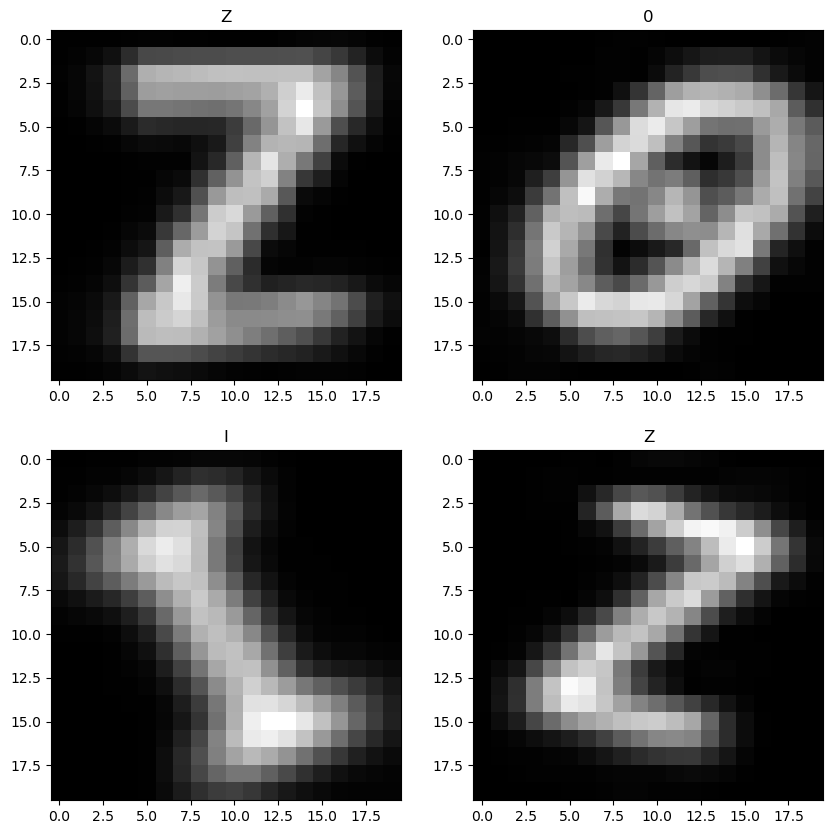

In [89]:
fig, axs = plt.subplots(2,2 , figsize=(10, 10))
for i in range(4):
    N = X.shape[0]
    n = np.random.randint(N)
    axs[i//2, i%2].imshow(X[n], cmap='gray')
    axs[i//2, i%2].set_title(itoc[np.argmax(Y[n])])


## 3.2: Data split

In [91]:
train_split = 0.9
N = X.shape[0]
n = int (N * train_split)
X_train = X[:n]
Y_train = Y[:n]
X_valid = X[n:]
Y_valid = Y[n:]

print(X_train.shape)
print(Y_train.shape)
print(X_valid.shape)
print(Y_valid.shape)

(64832, 20, 20)
(64832, 36)
(7204, 20, 20)
(7204, 36)


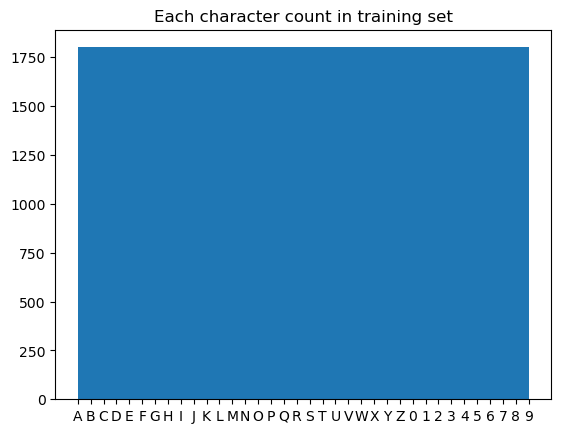

In [92]:
fig, axs = plt.subplots()
axs.hist(np.argmax(Y_train, axis=1), bins=36)
axs.set_title('Each character count in training set')
axs.set_xticks(range(36))
axs.set_xticklabels([c for c in list(ctoi.keys())])
print()

In [94]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), strides=(2,2), activation='relu', input_shape=(MODEL_INPUT_SIZE[0], MODEL_INPUT_SIZE[1], 1)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(36))
model.add(layers.Softmax())
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 9, 9, 32)          320       
                                                                 
 conv2d_4 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 conv2d_5 (Conv2D)           (None, 5, 5, 64)          36928     
                                                                 
 flatten_1 (Flatten)         (None, 1600)              0         
                                                                 
 dense_4 (Dense)             (None, 64)                102464    
                                                                 
 dense_5 (Dense)             (None, 64)                4160      
                                                                 
 dense_6 (Dense)             (None, 64)               

In [95]:
EPOCHS = 10

model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

if not LOAD_MODEL:
    history = model.fit(X_train, Y_train, epochs=EPOCHS, 
                        validation_data=(X_valid, Y_valid))
else:
    model = models.load_model(MODEL_LOAD_PATH)


Epoch 1/10
2026/2026 [==============================] - 18s 8ms/step - loss: 0.3387 - accuracy: 0.8974 - val_loss: 0.0542 - val_accuracy: 0.9833
Epoch 2/10
2026/2026 [==============================] - 16s 8ms/step - loss: 0.0666 - accuracy: 0.9795 - val_loss: 0.0556 - val_accuracy: 0.9832
Epoch 3/10
2026/2026 [==============================] - 16s 8ms/step - loss: 0.0463 - accuracy: 0.9864 - val_loss: 0.0450 - val_accuracy: 0.9865
Epoch 4/10
2026/2026 [==============================] - 16s 8ms/step - loss: 0.0400 - accuracy: 0.9887 - val_loss: 0.0904 - val_accuracy: 0.9781
Epoch 5/10
2026/2026 [==============================] - 15s 8ms/step - loss: 0.0297 - accuracy: 0.9915 - val_loss: 0.0219 - val_accuracy: 0.9943
Epoch 6/10
2026/2026 [==============================] - 15s 7ms/step - loss: 0.0290 - accuracy: 0.9918 - val_loss: 0.0901 - val_accuracy: 0.9832
Epoch 7/10
2026/2026 [==============================] - 15s 7ms/step - loss: 0.0260 - accuracy: 0.9933 - val_loss: 0.0158 - val_ac

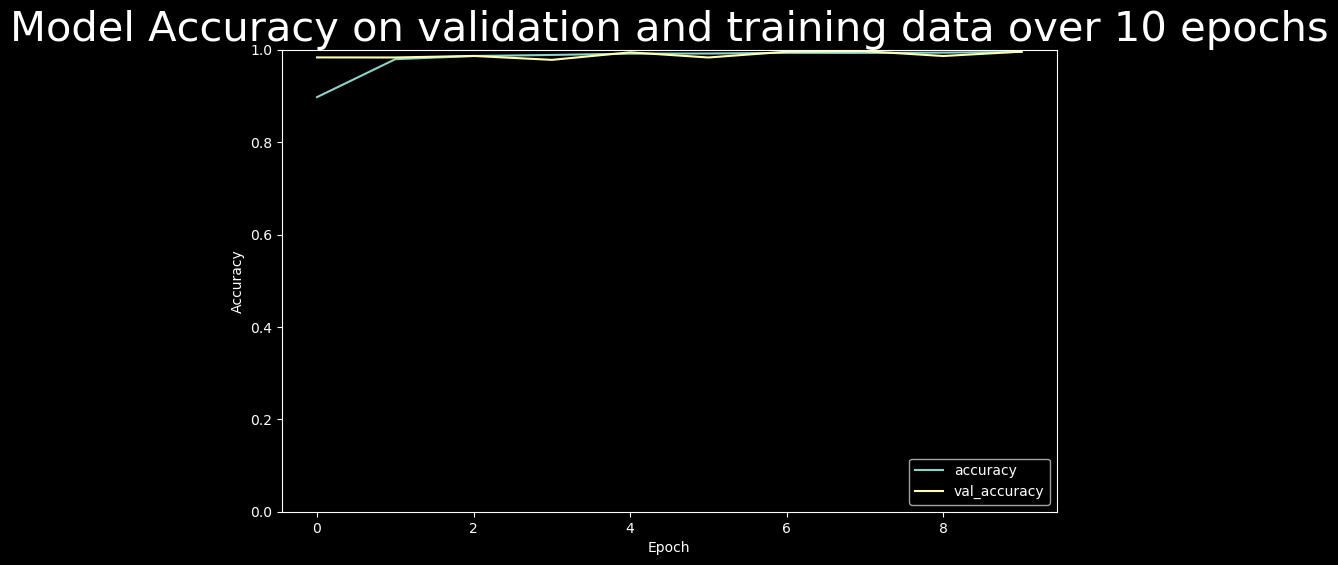

In [96]:

if not LOAD_MODEL:
    plt.style.use('dark_background')
    plt.figure(figsize=(10,6))
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.0, 1.0])
    plt.legend(loc='lower right')
    plt.title(f"Model Accuracy on validation and training data over {EPOCHS} epochs", size=30)

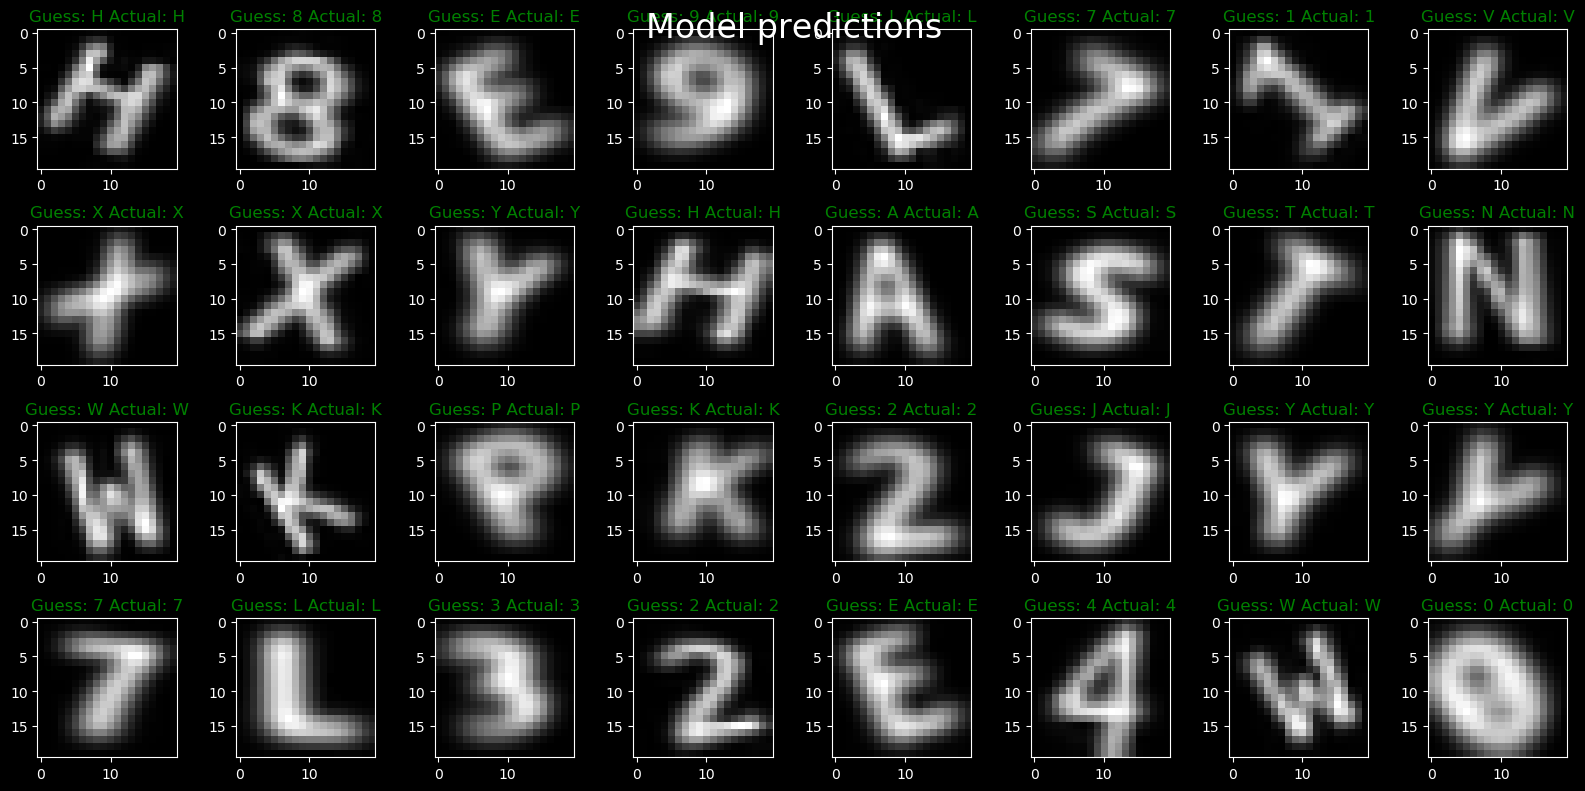

In [98]:

fig, axs = plt.subplots(4,8, figsize=(16,8))
for i in range(32):
    n = np.random.randint(X_valid.shape[0])
    input = tf.expand_dims(tf.expand_dims(X_valid[n], -1), 0)
    label = itoc[np.argmax(Y_valid[n])]
    ypred = str(itoc[np.argmax(model(input))])
    axs[i//8, i%8].imshow(X_valid[n], cmap='gray')
    if label == ypred:
        axs[i//8, i%8].set_title('Guess: ' + str(ypred) + ' Actual: ' + label, color='green')
    else:
        axs[i//8, i%8].set_title('Guess: ' + str(ypred) + ' Actual: ' + str(label), color='red')
fig.suptitle('Model predictions', fontsize=24)
fig.tight_layout()

In [99]:
model.save(MODEL_SAVE_PATH)

INFO:tensorflow:Assets written to: /home/fizzer/Insync/kmackenziesecondary@gmail.com/Google Drive - Shared with me/enph353_competition/assets/models/char_recog_resize_2/assets


INFO:tensorflow:Assets written to: /home/fizzer/Insync/kmackenziesecondary@gmail.com/Google Drive - Shared with me/enph353_competition/assets/models/char_recog_resize_2/assets


In [106]:
%%timeit -r 8 -n 8
n = np.random.randint(X_valid.shape[0])
input = tf.expand_dims(tf.expand_dims(X_valid[n], -1), 0)
label = itoc[np.argmax(Y_valid[n])]
ypred = str(itoc[np.argmax(model(input))])
# print(ypred)

2.82 ms ± 242 µs per loop (mean ± std. dev. of 8 runs, 8 loops each)


: 